In [147]:
pip install numpy torch botorch gpytorch scipy

In [148]:
import numpy as np
import torch
from botorch.models import SingleTaskGP
from botorch.acquisition import ExpectedImprovement, UpperConfidenceBound, PosteriorMean
from botorch.optim import optimize_acqf
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd

# Load your dataset
file_path = 'Combined_set_prescreened.csv'
total_info = pd.read_csv(file_path)
total_info

,MOF,uptake_ads,uptake_des,heat_ads,heat_des,LISD,LFSD,LISFS,Unit_cell_volume,Density,...,O,La,Cr,Ti,Ba,Rh,Ce,Cu,Al,Re
0,XUKYEI_neutral,0.920997,0.668303,-21.55231,-18.39099,13.18217,10.20370,13.18217,6140.000,0.287208,...,0,0,0,0,0,0,0,2,0,0
1,ja300034j_si_002_clean,0.433112,0.187346,-25.96441,-17.79542,17.49700,17.44104,17.49700,2800.680,0.713223,...,18,0,0,0,0,0,0,0,0,0
2,QIYDAF01_clean,0.827077,0.660425,-19.37443,-18.95302,22.00141,13.48659,22.00141,52812.600,0.303251,...,96,0,0,0,0,0,0,24,0,0
3,XAHPIH_clean,0.818678,0.634451,-21.96228,-19.54395,14.37026,13.22660,14.37026,12821.800,0.356183,...,40,0,0,0,0,0,0,8,0,0
4,VETMIS_clean,0.932519,0.746597,-22.10557,-19.92746,18.13430,11.96931,18.13430,33152.200,0.311959,...,48,0,0,0,0,0,0,12,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7180,AQOTIK_clean,0.026746,0.110716,-18.38246,-39.26981,6.80588,3.86300,6.80588,702.348,1.473480,...,0,0,0,0,0,0,0,0,0,0
7181,acs.inorgchem.6b00276_ic6b00276_si_006_clean,0.421515,0.395023,-39.33925,NaN,14.12459,8.71298,14.12459,54783.400,0.761320,...,240,0,0,0,0,0,0,0,0,0
7182,acs.inorgchem.6b01762_ic6b01762_si_002_clean,0.087637,0.074696,-30.35526,NaN,11.40609,8.52606,11.40609,23358.100,2.311980,...,548,0,0,0,0,0,0,0,0,0
7183,acs.inorgchem.6b02696_ic6b02696_si_002_clean,0.294982,0.280449,-34.78612,NaN,12.11622,5.03656,12.11622,70922.000,0.908718,...,384,0,0,0,0,0,0,0,0,0


In [149]:
total_info=total_info.dropna()
total_info

,MOF,uptake_ads,uptake_des,heat_ads,heat_des,LISD,LFSD,LISFS,Unit_cell_volume,Density,...,O,La,Cr,Ti,Ba,Rh,Ce,Cu,Al,Re
0,XUKYEI_neutral,0.920997,0.668303,-21.55231,-18.39099,13.18217,10.20370,13.18217,6140.000,0.287208,...,0,0,0,0,0,0,0,2,0,0
1,ja300034j_si_002_clean,0.433112,0.187346,-25.96441,-17.79542,17.49700,17.44104,17.49700,2800.680,0.713223,...,18,0,0,0,0,0,0,0,0,0
2,QIYDAF01_clean,0.827077,0.660425,-19.37443,-18.95302,22.00141,13.48659,22.00141,52812.600,0.303251,...,96,0,0,0,0,0,0,24,0,0
3,XAHPIH_clean,0.818678,0.634451,-21.96228,-19.54395,14.37026,13.22660,14.37026,12821.800,0.356183,...,40,0,0,0,0,0,0,8,0,0
4,VETMIS_clean,0.932519,0.746597,-22.10557,-19.92746,18.13430,11.96931,18.13430,33152.200,0.311959,...,48,0,0,0,0,0,0,12,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7176,AQIXUU_clean,0.001177,0.062873,-25.56586,-49.26611,5.00071,3.78897,5.00071,787.077,2.316180,...,18,0,0,0,0,0,0,0,0,0
7177,AFOVOH_clean,0.165457,0.232918,-28.96937,-40.77527,8.74251,6.51591,8.19585,1598.690,1.048160,...,12,0,0,0,0,0,0,0,0,0
7178,ATIJUJ_manual,0.038061,0.186922,-10.98116,-19.63789,17.44029,16.95446,17.44029,3081.950,0.753394,...,18,0,0,0,0,0,0,0,0,0
7179,AFOVEX_clean,0.172913,0.244083,-29.31178,-38.54721,8.76979,6.57643,8.76042,1626.110,1.022060,...,12,0,0,0,0,0,2,0,0,0


In [166]:
# Data preprocessing
total_info_cleaned = total_info.dropna()
uptake_ads = total_info_cleaned['uptake_ads']
uptake_des = total_info_cleaned['uptake_des']
heat_ads = total_info_cleaned['heat_ads']
heat_des = total_info_cleaned['heat_des']

# Given constants
delta_H_vap_Tev = 16.25          # Example value in kJ/mol
M_w = 0.044097                   # Molar mass in kg/mol
C_sorbent_p = 1                  # Specific heat capacity in kJ/(kg*K)
T_des = 358.15                   # Desorption temperature in Kelvin
T1 = 313.13                      # Initial temperature in Kelvin

# Calculate Δq
delta_q = uptake_ads - uptake_des

# Drop rows with negative Δq
filtered_indices = delta_q >= 0
total_info_cleaned = total_info_cleaned[filtered_indices].copy()
delta_q = delta_q[filtered_indices]

# Calculate <ΔH_ads>
avg_delta_H_ads = (heat_ads + heat_des) / 2
avg_delta_H_ads = avg_delta_H_ads[filtered_indices]

# Calculate COP_R for each row
total_info_cleaned.loc[:, 'COP_R'] = (delta_H_vap_Tev * delta_q) / ((M_w * C_sorbent_p * (T_des - T1)) - (delta_q * avg_delta_H_ads))

# Select target and features
target = total_info_cleaned['COP_R']
features = total_info_cleaned.drop(columns=["MOF", "uptake_ads", "heat_ads", "uptake_des", "heat_des", "Pu", "COP_R"])
names=total_info_cleaned['MOF']
# Convert to numpy arrays
X = features.values
y = target.values
total_info_cleaned.to_excel('total_info_cleaned_with_COP_calculated.xlsx', index=False)

In [167]:
total_info_cleaned=total_info_cleaned.drop(columns=["Pu","uptake_ads","uptake_des","heat_ads","heat_des","MOF"])

In [168]:
total_info_cleaned

,LISD,LFSD,LISFS,Unit_cell_volume,Density,ASA_A2,ASA_m2_per_cm3,ASA_m2_per_g,NASA_A2,NASA_m2_per_cm3,...,La,Cr,Ti,Ba,Rh,Ce,Cu,Al,Re,COP_R
0,13.18217,10.20370,13.18217,6140.000,0.287208,1122.8100,1828.680,6367.080,0.0000,0.000,...,0,0,0,0,0,0,2,0,0,0.583945
1,17.49700,17.44104,17.49700,2800.680,0.713223,390.5410,1394.450,1955.140,0.0000,0.000,...,0,0,0,0,0,0,0,0,0,0.542431
2,22.00141,13.48659,22.00141,52812.600,0.303251,8995.1500,1703.220,5616.540,0.0000,0.000,...,0,0,0,0,0,0,24,0,0,0.522907
3,14.37026,13.22660,14.37026,12821.800,0.356183,2130.4900,1661.620,4665.070,0.0000,0.000,...,0,0,0,0,0,0,8,0,0,0.515395
4,18.13430,11.96931,18.13430,33152.200,0.311959,5856.6500,1766.600,5662.900,0.0000,0.000,...,0,0,0,0,0,0,12,0,0,0.512710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6912,6.56302,4.77517,6.56302,3664.890,1.599000,394.0410,1075.180,672.406,0.0000,0.000,...,0,0,0,0,0,0,0,0,0,0.000327
6913,5.67220,3.42753,4.50995,1630.010,2.827110,75.6807,464.295,164.230,67.0363,411.263,...,0,0,0,2,0,0,0,0,0,0.000246
6914,4.90669,3.50214,4.90669,847.141,1.567280,37.4215,441.738,281.850,0.0000,0.000,...,0,0,0,0,0,0,0,0,0,0.000137
6915,5.16636,4.13343,5.13222,17478.700,2.019600,806.0660,461.169,228.346,0.0000,0.000,...,0,0,0,0,0,0,64,0,0,0.000066


In [169]:
import numpy as np
import torch
from botorch.models import SingleTaskGP
from botorch.acquisition import ExpectedImprovement, UpperConfidenceBound, PosteriorMean
from botorch.optim import optimize_acqf
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from scipy.stats import norm
import pandas as pd
import time
import pickle
import openpyxl

In [172]:
import numpy as np
import torch
from botorch.models import SingleTaskGP
from botorch.optim import optimize_acqf
from botorch.acquisition import ExpectedImprovement, UpperConfidenceBound, PosteriorMean
from gpytorch.mlls import ExactMarginalLogLikelihood
import pickle
import time
import pandas as pd

def dynamic_beta(iteration, beta0=0.05, rate=0.1):
    """
    Dynamic beta function that increases with the number of iterations.
    Adjust beta0 and rate as needed.
    """
    return beta0 * (1 + rate * np.log(iteration + 1))

def bo_run(X_labelled, y_labelled, X_unlabelled, unlabelled_indices, unlabelled_names, nb_iterations, nb_COFs_initialization, which_acquisition, verbose=False, store_explore_exploit_terms=False):
    assert nb_iterations > nb_COFs_initialization
    assert which_acquisition in ['max y_hat', 'EI', 'max sigma']

    ids_acquired_labelled = np.random.choice(np.arange(X_labelled.shape[0]), size=nb_COFs_initialization, replace=False)
    ids_acquired_unlabelled = []

    if which_acquisition == "EI" and store_explore_exploit_terms:
        explore_exploit_balance = np.array([(np.NaN, np.NaN) for i in range(nb_iterations)])
    else:
        explore_exploit_balance = []

    # Initialize acquired y
    y_acquired = y_labelled[ids_acquired_labelled]

    for i in range(nb_COFs_initialization, nb_iterations):
        print("iteration:", i, end="\r")
        
        # Construct and fit GP model
        model = SingleTaskGP(torch.tensor(X_labelled[ids_acquired_labelled, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        
        # Fit the GP model
        model.train()
        mll.train()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
        optimizer.zero_grad()
        output = model(model.train_inputs[0])
        loss = -mll(output, model.train_targets)
        loss.backward()
        optimizer.step()
        
        # Set up acquisition function
        if which_acquisition == "EI":
            acquisition_function = ExpectedImprovement(model, best_f=y_acquired.max().item())
        elif which_acquisition == "max y_hat":
            acquisition_function = PosteriorMean(model)
        elif which_acquisition == "max sigma":
            beta = dynamic_beta(i)
            acquisition_function = UpperConfidenceBound(model, beta=beta)
        else:
            raise Exception("not a valid acquisition function")

        # Optimize the acquisition function on X_unlabelled
        new_x, _ = optimize_acqf(
            acquisition_function,
            bounds=torch.stack([torch.tensor(X_unlabelled.min(0)), torch.tensor(X_unlabelled.max(0))], 0).to(torch.float32),
            q=1,
            num_restarts=10,
            raw_samples=20,
        )

        # Convert new_x to numpy
        new_x_np = new_x.detach().numpy().reshape(-1)

        # Find the closest point in X_unlabelled
        distances = np.sum((X_unlabelled - new_x_np)**2, axis=1)
        id_max_acquisition = np.argmin(distances)
        original_index = unlabelled_indices[id_max_acquisition]
        data_object_name = unlabelled_names[id_max_acquisition]

        # Prompt user for the target value of the acquired data point
        user_target_value = float(input(f"Enter the target value for the acquired data point '{data_object_name}': "))

        # Acquire this COF
        ids_acquired_unlabelled.append(original_index)
        
        # Update X_labelled and y_labelled with the new data point and target value
        X_labelled = np.vstack((X_labelled, X_unlabelled[id_max_acquisition, :]))
        y_acquired = np.concatenate((y_acquired, [user_target_value]))
        
        # Update the ids_acquired_labelled list to include the new index
        ids_acquired_labelled = np.arange(len(y_acquired))
        
        # Remove the acquired data point from X_unlabelled and unlabelled_names
        X_unlabelled = np.delete(X_unlabelled, id_max_acquisition, axis=0)
        unlabelled_indices = np.delete(unlabelled_indices, id_max_acquisition)
        unlabelled_names = np.delete(unlabelled_names, id_max_acquisition)

        if verbose:
            print("\tacquired COF", data_object_name, "with user-provided y =", user_target_value)
            print("\tbest y acquired:", y_acquired.max())
        
    return ids_acquired_unlabelled, explore_exploit_balance



# Run Bayesian Optimization
which_acquisition = "max sigma"
nb_COFs_initializations = {"EI": [5, 10, 15, 20, 25], "max y_hat": [10], "max sigma": [20]}
nb_runs = 1
nb_iterations = 30
time1 = 0
for nb_COFs_initialization in nb_COFs_initializations[which_acquisition]:
    print("# COFs in initialization:", nb_COFs_initialization)
    bo_res = dict()
    bo_res['ids_acquired'] = []
    bo_res['explore_exploit_balance'] = []
    
    if nb_COFs_initialization == 10 and which_acquisition == 'EI':
        store_explore_exploit_terms = True
    else:
        store_explore_exploit_terms = False
    
    for r in range(nb_runs):
        print("\nRUN", r)
        t0 = time.time()
        # Assuming total_info_cleaned is your DataFrame and 'names' is a list or Series containing names for the data objects
        total_info_cleaned['MOF'] = names
        
        # Sample 20 data points for X_labelled and drop the 'MOF' column
        X_labelled = total_info_cleaned.sample(n=20, replace=False)
        y_labelled = X_labelled['COP_R'].values
        X_labelled = X_labelled.drop(columns=['MOF', 'COP_R'])
        
        # Create X_unlabelled with the remaining data objects and drop 'MOF' and 'COP_R' columns
        unlabelled_data = total_info_cleaned.drop(X_labelled.index)
        unlabelled_indices = unlabelled_data.index
        unlabelled_names = unlabelled_data['MOF'].values
        X_unlabelled = unlabelled_data.drop(columns=['MOF', 'COP_R'])
        
        # Convert to numpy arrays
        X_labelled = X_labelled.values
        X_unlabelled = X_unlabelled.values
        ids_acquired, explore_exploit_balance = bo_run(X_labelled, y_labelled, X_unlabelled, unlabelled_indices, unlabelled_names, nb_iterations, nb_COFs_initialization, which_acquisition, store_explore_exploit_terms=store_explore_exploit_terms)
        
        bo_res['ids_acquired'].append(ids_acquired)
        bo_res['explore_exploit_balance'].append(explore_exploit_balance)
        time1 += ((time.time() - t0) / 60)
        print("took time t = ", (time.time() - t0) / 60, "min\n")
    
    with open('bo_results_' + which_acquisition + "_initiate_with_{0}".format(nb_COFs_initialization) + '.pkl', 'wb') as file:
        pickle.dump(bo_res, file)
        
with open('bo_results_nb_COF_initializations.pkl', 'wb') as file:
    pickle.dump(nb_COFs_initializations, file)
print(time1)


C:\Users\kumar\AppData\Local\Temp\ipykernel_23896\2003124896.py:37: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X_labelled[ids_acquired_labelled, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1141]), mean = tensor([0.1207])). Please consider scaling the input to zero mean and unit va

# COFs in initialization: 20

RUN 0


Enter the target value for the acquired data point 'LAFRAN01_clean':  0.11162291


C:\Users\kumar\AppData\Local\Temp\ipykernel_23896\2003124896.py:37: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X_labelled[ids_acquired_labelled, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1112]), mean = tensor([0.1203])). Please consider scaling the input to zero mean and unit va

Enter the target value for the acquired data point 'OCUNAC_manual':  0.319043423


C:\Users\kumar\AppData\Local\Temp\ipykernel_23896\2003124896.py:37: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X_labelled[ids_acquired_labelled, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1165]), mean = tensor([0.1293])). Please consider scaling the input to zero mean and unit va

Enter the target value for the acquired data point 'CUSYAR_clean':  0.274510718


C:\Users\kumar\AppData\Local\Temp\ipykernel_23896\2003124896.py:37: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X_labelled[ids_acquired_labelled, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1178]), mean = tensor([0.1356])). Please consider scaling the input to zero mean and unit va

Enter the target value for the acquired data point 'BODPAN_clean':  0.176303632


C:\Users\kumar\AppData\Local\Temp\ipykernel_23896\2003124896.py:37: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X_labelled[ids_acquired_labelled, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1155]), mean = tensor([0.1373])). Please consider scaling the input to zero mean and unit va

Enter the target value for the acquired data point 'LIBHAH_clean':  0.232807912


C:\Users\kumar\AppData\Local\Temp\ipykernel_23896\2003124896.py:37: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X_labelled[ids_acquired_labelled, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1147]), mean = tensor([0.1411])). Please consider scaling the input to zero mean and unit va

Enter the target value for the acquired data point 'IMUKUW_clean':  0.247684912


C:\Users\kumar\AppData\Local\Temp\ipykernel_23896\2003124896.py:37: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X_labelled[ids_acquired_labelled, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1143]), mean = tensor([0.1452])). Please consider scaling the input to zero mean and unit va

Enter the target value for the acquired data point 'ja403810k_si_002_clean':  0.182051438


C:\Users\kumar\AppData\Local\Temp\ipykernel_23896\2003124896.py:37: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X_labelled[ids_acquired_labelled, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1123]), mean = tensor([0.1466])). Please consider scaling the input to zero mean and unit va

Enter the target value for the acquired data point 'c6ce00407e_c6ce00407e6_clean':  0.073675678


C:\Users\kumar\AppData\Local\Temp\ipykernel_23896\2003124896.py:37: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X_labelled[ids_acquired_labelled, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1111]), mean = tensor([0.1440])). Please consider scaling the input to zero mean and unit va

Enter the target value for the acquired data point 'NIBHOW_clean':  0.430441108


C:\Users\kumar\AppData\Local\Temp\ipykernel_23896\2003124896.py:37: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  model = SingleTaskGP(torch.tensor(X_labelled[ids_acquired_labelled, :], dtype=torch.float32), torch.tensor(y_acquired, dtype=torch.float32).unsqueeze(-1))
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\botorch\models\utils\assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.1213]), mean = tensor([0.1539])). Please consider scaling the input to zero mean and unit va

Enter the target value for the acquired data point 'XAHPUT_clean':  0.049814713


took time t =  5.682869140307108 min

5.682869140307108


In [174]:
# Save results to Excel
# Create a new workbook and add a sheet
workbook = openpyxl.Workbook()
sheet = workbook.active
sheet.title = 'BO Results'

# Add headers
headers = ['Run', 'Iteration', 'COF ID', 'Y Value']
sheet.append(headers)

for nb_COFs_initialization in nb_COFs_initializations[which_acquisition]:
    with open('bo_results_' + which_acquisition + "_initiate_with_{0}".format(nb_COFs_initialization) + '.pkl', 'rb') as file:
        bo_res = pickle.load(file)
    
    for r in range(nb_runs):
        ids_acquired = bo_res['ids_acquired'][r]
        y_values = y[ids_acquired]
        
        for i, (cof_id, y_val) in enumerate(zip(ids_acquired, y_values)):
            sheet.append([r, i, cof_id, y_val])
workbook.save('bo_results10.xlsx')
print("Results saved to bo_results10.xlsx")

Results saved to bo_results10.xlsx


Mean max y: 0.43044110834699545
Standard deviation of max y: 0.0


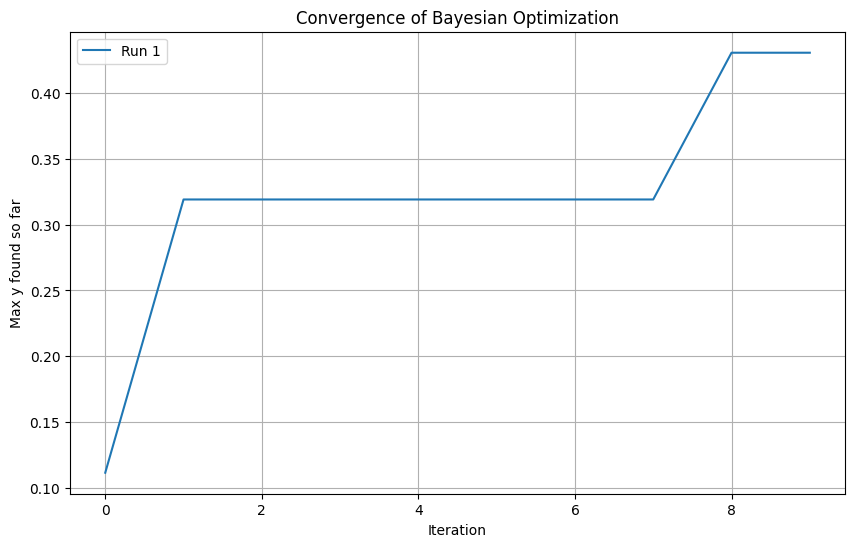

Random search mean max y: 0.23099051433224996
Random search standard deviation of max y: 0.0


In [173]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

# Load the results from the BO
with open('bo_results_' + which_acquisition + "_initiate_with_{0}".format(nb_COFs_initialization) + '.pkl', 'rb') as file:
    bo_res = pickle.load(file)

# Initialize arrays to store the results
max_y_per_run = []
convergence_curves = []

# Loop over the runs to collect the max y values and convergence data
for r in range(nb_runs):
    ids_acquired = bo_res['ids_acquired'][r]
    y_values = y[ids_acquired]
    max_y_per_run.append(y_values.max())
    
    # Store the max y found so far for each iteration
    convergence_curve = [y_values[:i].max() for i in range(1, len(y_values) + 1)]
    convergence_curves.append(convergence_curve)

# Compute the mean and standard deviation of the max y values
mean_max_y = np.mean(max_y_per_run)
std_max_y = np.std(max_y_per_run)

print(f"Mean max y: {mean_max_y}")
print(f"Standard deviation of max y: {std_max_y}")

# Plot the convergence curves
plt.figure(figsize=(10, 6))
for r in range(nb_runs):
    plt.plot(convergence_curves[r], label=f'Run {r+1}')

plt.xlabel('Iteration')
plt.ylabel('Max y found so far')
plt.title('Convergence of Bayesian Optimization')
plt.legend()
plt.grid(True)
plt.show()

# Compare with random search
random_max_y = []
for _ in range(nb_runs):
    random_ids = np.random.choice(np.arange(X.shape[0]), size=nb_iterations, replace=False)
    random_y_values = y[random_ids]
    random_max_y.append(random_y_values.max())

mean_random_max_y = np.mean(random_max_y)
std_random_max_y = np.std(random_max_y)

print(f"Random search mean max y: {mean_random_max_y}")
print(f"Random search standard deviation of max y: {std_random_max_y}")


In [175]:
file_path = 'bo_results10.xlsx'
obtained_bo = pd.read_excel(file_path)
obtained_bo

,Run,Iteration,COF ID,Y Value
0,0,0,2777,0.111623
1,0,1,216,0.319043
2,0,2,364,0.274511
3,0,3,1124,0.176304
4,0,4,568,0.232808
5,0,5,441,0.247685
6,0,6,1149,0.182051
7,0,7,4371,0.073676
8,0,8,52,0.430441
9,0,9,5304,0.049815


In [176]:
# Remove duplicates based on the 'cof id' column
obtained_bo = obtained_bo.drop_duplicates(subset=['COF ID'])
obtained_bo

,Run,Iteration,COF ID,Y Value
0,0,0,2777,0.111623
1,0,1,216,0.319043
2,0,2,364,0.274511
3,0,3,1124,0.176304
4,0,4,568,0.232808
5,0,5,441,0.247685
6,0,6,1149,0.182051
7,0,7,4371,0.073676
8,0,8,52,0.430441
9,0,9,5304,0.049815


In [177]:
unique_cof_ids = obtained_bo['COF ID'].unique()

# Filter the total_info_cleaned DataFrame to include only rows with indices in the unique_cof_ids
filtered_total_info = total_info_cleaned.loc[total_info_cleaned.index.isin(unique_cof_ids)]

# Save the filtered DataFrame back to Excel
filtered_total_info.to_excel('total_info_filtered.xlsx', index=False)
filtered_total_info

,LISD,LFSD,LISFS,Unit_cell_volume,Density,ASA_A2,ASA_m2_per_cm3,ASA_m2_per_g,NASA_A2,NASA_m2_per_cm3,...,Cr,Ti,Ba,Rh,Ce,Cu,Al,Re,COP_R,MOF
52,27.96102,15.14045,27.96102,25357.3,0.279595,3627.92,1430.72,5117.13,0.00,0.00,...,0,0,0,0,0,12,0,0,0.430441,NIBHOW_clean
216,36.15060,14.03234,36.15060,175465.0,0.427517,23951.80,1365.05,3192.96,0.00,0.00,...,204,0,0,0,0,0,0,0,0.319043,OCUNAC_manual
364,28.58417,12.17996,28.50857,144401.0,0.247232,20479.40,1418.23,5736.43,0.00,0.00,...,0,0,0,0,0,0,0,0,0.274511,CUSYAR_clean
441,12.16588,7.63168,12.16588,133619.0,0.600216,28869.90,2160.62,3599.73,0.00,0.00,...,0,0,0,0,0,0,0,0,0.247685,IMUKUW_clean
568,22.23808,16.58374,22.23808,131228.0,0.731780,19708.00,1501.81,2052.28,0.00,0.00,...,0,0,0,0,0,0,0,0,0.232808,LIBHAH_clean
1124,13.15410,6.77246,13.13815,144768.0,0.888078,27989.40,1933.40,2177.06,0.00,0.00,...,0,0,0,0,0,384,0,0,0.176304,BODPAN_clean
1149,24.50867,19.56277,24.50861,119391.0,0.396669,13106.70,1097.80,2767.56,0.00,0.00,...,0,0,0,0,0,0,0,0,0.182051,ja403810k_si_002_clean
2777,12.98217,4.40669,12.98216,260860.0,0.722993,37431.30,1434.92,1984.70,6587.49,252.53,...,0,0,0,0,0,0,0,0,0.111623,LAFRAN01_clean
4371,31.09673,11.89205,31.09673,438839.0,0.244057,61159.40,1393.66,5710.41,0.00,0.00,...,0,0,0,0,0,0,0,0,0.073676,c6ce00407e_c6ce00407e6_clean
5304,21.56974,20.14995,21.56974,38661.3,0.178675,4383.66,1133.86,6345.92,0.00,0.00,...,0,0,0,0,0,8,0,0,0.049815,XAHPUT_clean


In [178]:
# Store the rest of the data objects which were not selected
not_selected_total_info = total_info_cleaned.loc[~total_info_cleaned.index.isin(unique_cof_ids)]
not_selected_total_info.to_excel('filtered_info_not_selected.xlsx', index=False)
not_selected_total_info

,LISD,LFSD,LISFS,Unit_cell_volume,Density,ASA_A2,ASA_m2_per_cm3,ASA_m2_per_g,NASA_A2,NASA_m2_per_cm3,...,Cr,Ti,Ba,Rh,Ce,Cu,Al,Re,COP_R,MOF
0,13.18217,10.20370,13.18217,6140.000,0.287208,1122.8100,1828.680,6367.080,0.0000,0.000,...,0,0,0,0,0,2,0,0,0.583945,XUKYEI_neutral
1,17.49700,17.44104,17.49700,2800.680,0.713223,390.5410,1394.450,1955.140,0.0000,0.000,...,0,0,0,0,0,0,0,0,0.542431,ja300034j_si_002_clean
2,22.00141,13.48659,22.00141,52812.600,0.303251,8995.1500,1703.220,5616.540,0.0000,0.000,...,0,0,0,0,0,24,0,0,0.522907,QIYDAF01_clean
3,14.37026,13.22660,14.37026,12821.800,0.356183,2130.4900,1661.620,4665.070,0.0000,0.000,...,0,0,0,0,0,8,0,0,0.515395,XAHPIH_clean
4,18.13430,11.96931,18.13430,33152.200,0.311959,5856.6500,1766.600,5662.900,0.0000,0.000,...,0,0,0,0,0,12,0,0,0.512710,VETMIS_clean
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6912,6.56302,4.77517,6.56302,3664.890,1.599000,394.0410,1075.180,672.406,0.0000,0.000,...,0,0,0,0,0,0,0,0,0.000327,SANHUN_clean
6913,5.67220,3.42753,4.50995,1630.010,2.827110,75.6807,464.295,164.230,67.0363,411.263,...,0,0,2,0,0,0,0,0,0.000246,PEKVUY_clean
6914,4.90669,3.50214,4.90669,847.141,1.567280,37.4215,441.738,281.850,0.0000,0.000,...,0,0,0,0,0,0,0,0,0.000137,HEXNII_clean
6915,5.16636,4.13343,5.13222,17478.700,2.019600,806.0660,461.169,228.346,0.0000,0.000,...,0,0,0,0,0,64,0,0,0.000066,IBIYUO_clean


|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | -0.001678 | 18.11     | 19.06     | 22.5      | 199.7     |
| 2         | -0.001477 | 10.46     | 3.964     | 3.626     | 266.5     |
| 3         | -0.00162  | 26.04     | 14.45     | 2.576     | 292.5     |
| 4         | -0.001493 | 34.14     | 5.034     | 7.091     | 95.85     |
| 5         | -0.001578 | 15.65     | 10.97     | 14.09     | 122.8     |
| 6         | -0.001476 | 26.41     | 3.65      | 10.18     | 141.6     |
| 7         | -0.00166  | 20.96     | 15.92     | 7.591     | 178.6     |
| 8         | -0.001502 | 25.73     | 1.883     | 19.01     | 92.63     |
| 9         | -0.001676 | 7.277     | 19.03     | 29.04     | 252.1     |
| 10        | -0.001502 | 15.66     | 2.856     | 21.16     | 160.0     |
| 11        | -0.001515 | 31.01     | 1.256     | 27.21     | 146.6     |
| 12        | -0.00148  | 39.09     | 

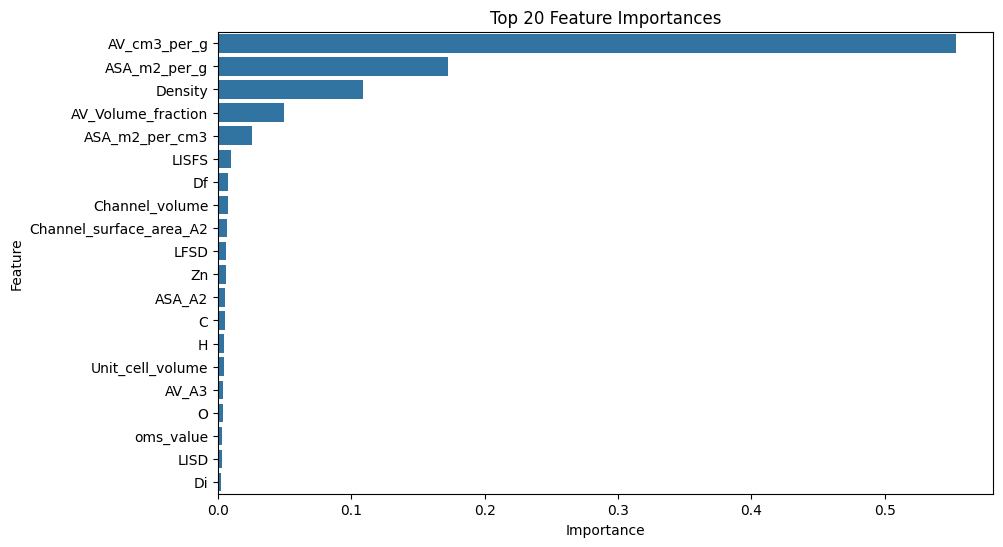

Number of important features: 50
Mean Squared Error: 0.0014680850313124473
R2 Score: 0.7742855785028695


In [44]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
# Replace 'filtered_total_info.csv' and 'not_selected_total_info.csv' with the actual file paths
filtered_total_info = pd.read_excel('total_info_filtered.xlsx')
not_selected_total_info = pd.read_excel('filtered_info_not_selected.xlsx')

# Separate features and target variable
X_filtered = filtered_total_info.drop(columns=['COP_R'])
y_filtered = filtered_total_info['COP_R']
X_not_selected = not_selected_total_info.drop(columns=['COP_R'])
y_not_selected = not_selected_total_info['COP_R']

# Split the data into training and test sets
X_train, y_train = X_filtered, y_filtered
X_test, y_test = X_not_selected, y_not_selected

# Define the function for cross-validation
def rf_cv(n_estimators, max_depth, min_samples_split, min_samples_leaf):
    rf = RandomForestRegressor(
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        min_samples_split=int(min_samples_split),
        min_samples_leaf=int(min_samples_leaf),
        random_state=42
    )
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    return -mean_squared_error(y_test, y_pred)

# Define the parameter bounds
param_bounds = {
    'n_estimators': (50, 300),
    'max_depth': (5, 40),
    'min_samples_split': (2, 30),
    'min_samples_leaf': (1, 20)
}

# Initialize Bayesian Optimization
optimizer = BayesianOptimization(
    f=rf_cv,
    pbounds=param_bounds,
    random_state=42
)

# Perform optimization
optimizer.maximize(
    init_points=10,
    n_iter=20
)

# Extract the best parameters
best_params = optimizer.max['params']
best_params = {
    'n_estimators': int(best_params['n_estimators']),
    'max_depth': int(best_params['max_depth']),
    'min_samples_split': int(best_params['min_samples_split']),
    'min_samples_leaf': int(best_params['min_samples_leaf'])
}
print(f"Best parameters found: {best_params}")

# Train the Random Forest Regressor with the best parameters
best_rf = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)
best_rf.fit(X_train, y_train)

# Calculate feature importance
importances = best_rf.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
plt.title('Top 20 Feature Importances')
plt.show()

# Filter features based on importance threshold
threshold = 0.0001
important_features = feature_importance_df[abs(feature_importance_df['Importance']) > threshold]['Feature'].tolist()
print(f"Number of important features: {len(important_features)}")

# Select only the important features
X_train_filtered = X_train[important_features]
X_test_filtered = X_test[important_features]

# Train a new Random Forest Regressor with filtered features
rf_filtered = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)
rf_filtered.fit(X_train_filtered, y_train)

# Predict on the test set
y_pred = rf_filtered.predict(X_test_filtered)

# Evaluate the model accuracy using mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Calculate other metrics such as R2 score
r2 = r2_score(y_test, y_pred)
print(f"R2 Score: {r2}")
